# Forecasting Walmart sales with Treeffuser

In this tutorial we show how to use Treeffuser to model and forecast Walmart sales using the M5 forecasting dataset from Kaggle.

## Getting started


To get started, we first install `treeffuser` and import the relevant libraries (if needed).

!pip install treeffuser

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from pathlib import Path

from tqdm import tqdm
from treeffuser import Treeffuser

# load autoreload extension
%load_ext autoreload
%autoreload 2

Next, create a Kaggle account and download the data from https://www.kaggle.com/competitions/m5-forecasting-accuracy/data.

If you're running this notebook in Colab, manually upload the necessary files (`calendar.csv`, `sales_train_validation.csv`, `sell_prices.csv`) to Colab by clicking the `Files` tab on the left sidebar and selecting `Upload`. Move the files into a new folder named `m5`. Once uploaded, the notebook will be able to read and process the data.

If you're running this on your local machine, you can also use Kaggle's [command-line tool](https://www.kaggle.com/docs/api) and run the following from the command line:

```bash
cd ./m5 # path to folder where you want to save the data
kaggle competitions download -c m5-forecasting-accuracy
```

Use your favorite tool to unzip the archive. In Linux/macOS,

```bash
unzip m5-forecasting-accuracy.zip
```

We'll be using the following files: `calendar.csv`, `sales_train_validation.csv`, and `sell_prices.csv`.


<!-- - `calendar.csv` - Contains information about the dates on which the products are sold.
- `sales_train_validation.csv` - Contains the historical daily unit sales data per product and store `[d_1 - d_1913]`.
- `sell_prices.csv` - Contains information about the price of the products sold per store and date. -->
<!-- - `sales_train_evaluation.csv`- Includes sales [`d_1 - d_1941]` (labels used for the Public leaderboard). -->
<!-- - `sample_submission.csv` - The correct format for submissions. Reference the Evaluation tab for more info. -->

#### Load the data

In [2]:
data_path = Path("./m5")  # change with path where you extracted the data archive

calendar_df = pd.read_csv(data_path / "calendar.csv")
sales_train_df = pd.read_csv(data_path / "sales_train_validation.csv")
sell_prices_df = pd.read_csv(data_path / "sell_prices.csv")

# add explicit columns for the day, month, year for ease of processing
calendar_df["date"] = pd.to_datetime(calendar_df["date"])
calendar_df["day"] = calendar_df["date"].dt.day
calendar_df["month"] = calendar_df["date"].dt.month
calendar_df["year"] = calendar_df["date"].dt.year

## The data

### Preprocessing
`sell_prices_df` contains the prices of each item in each store at a given time. The `wm_yr_wk` is a unique identifier for the time.

In [3]:
sell_prices_df.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


`calendar_df` contains information about the dates on which the products were sold.

In [4]:
calendar_df.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,day
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0,29
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0,30
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0,31
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0,1
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1,2


`sales_train_df` contains the number of units sold for an item in each department and store. The sales are grouped by day: for example, the `d_1907` column has the number of units sold on the 1907-th day.

In [5]:
sales_train_df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


To align the sales data with the other DataFrames, we convert `sales_train_df` to a long format. We collapse the daily sales columns `d_{i}` into a single `sales` column, with an  additional `day` column indicating the day corresponding to each sales entry.

In [6]:
def convert_sales_data_from_wide_to_long(sales_df_wide):
    index_vars = ["item_id", "dept_id", "cat_id", "store_id", "state_id"]
    sales_df_long = pd.wide_to_long(
        sales_df_wide.iloc[:100, 1:],
        i=index_vars,
        j="day",
        stubnames=["d"],
        sep="_",
    ).reset_index()

    sales_df_long = sales_df_long.rename(columns={"d": "sales", "day": "d"})

    sales_df_long["d"] = "d_" + sales_df_long["d"].astype(
        "str"
    )  # restore "d_{i}" format for day
    return sales_df_long


sales_train_df_long = convert_sales_data_from_wide_to_long(sales_train_df)
sales_train_df_long.head()

,item_id,dept_id,cat_id,store_id,state_id,d,sales
0,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
1,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_2,0
2,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_3,0
3,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_4,0
4,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_5,0


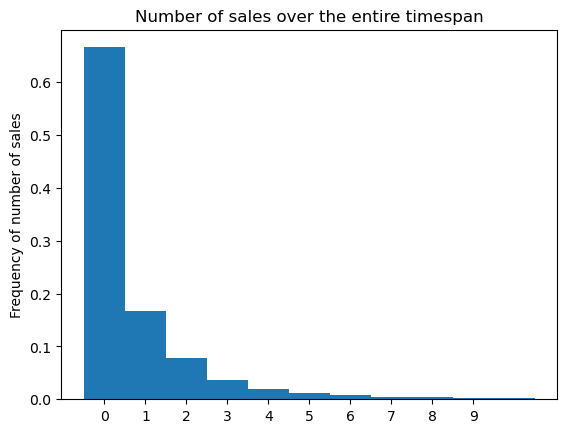

In [7]:
plt.hist(
    sales_train_df_long["sales"],
    bins=np.arange(0, 10 + 1.5) - 0.5,
    range=[0, 10],
    density=True,
)
plt.xticks(range(10))
plt.ylabel("Frequency of number of sales")
plt.title("Number of sales over the entire timespan");

### Train and test sets

The dataset comprises sales data of 100 items over 1,913 days. For simplicity, we select the data from the first 365 days and discard the rest.

In [8]:
print(f"n_items = {len(sales_train_df_long['item_id'].unique())}")
print(f"n_days = {len(sales_train_df_long['d'].unique())}")

sales_train_df_long["day_number"] = sales_train_df_long["d"].str.extract("(\d+)").astype(int)
data = sales_train_df_long[sales_train_df_long["day_number"] <= 365].copy()

n_items = 100
n_days = 1913


We compute the lags of the previous 30 days and merge the sales, calendar, and price data together.

In [9]:
n_lags = 30

# sort data before computing lags
data_index_vars = ["item_id", "dept_id", "cat_id", "store_id", "state_id"]
data.sort_values(data_index_vars + ["day_number"], inplace=True)

for lag in range(1, n_lags + 1):
    data[f"sales_lag_{lag}"] = data.groupby(by=data_index_vars)["sales"].shift(lag)

data = data.merge(calendar_df).merge(sell_prices_df)

data.head()

,item_id,dept_id,cat_id,store_id,state_id,d,sales,day_number,sales_lag_1,sales_lag_2,...,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,day,sell_price
0,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_141,0,141,0.0,0.0,...,2011,NaN,NaN,NaN,NaN,0,0,0,18,3.97
1,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_142,0,142,0.0,0.0,...,2011,Father's day,Cultural,NaN,NaN,0,0,0,19,3.97
2,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_143,0,143,0.0,0.0,...,2011,NaN,NaN,NaN,NaN,0,0,0,20,3.97
3,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_144,1,144,0.0,0.0,...,2011,NaN,NaN,NaN,NaN,0,0,0,21,3.97
4,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_145,0,145,1.0,0.0,...,2011,NaN,NaN,NaN,NaN,0,0,0,22,3.97


Treeffuser can handle **categorical columns**, but the dtype of those columns must be set to `category` in the DataFrame.

In [10]:
categorical_columns = [
    "item_id",
    "dept_id",
    "cat_id",
    "store_id",
    "state_id",
    "d",
    "wm_yr_wk",
    "weekday",
    "event_name_1",
    "event_type_1",
    "event_name_2",
    "event_type_2",
    "snap_CA",
    "snap_TX",
    "snap_WI",
]
data[categorical_columns] = data[categorical_columns].astype("category")


Finally, for each item, we take the first 300 days as train data and use the remaining 65 data as test data for evaluation.

In [11]:
is_train = data["day_number"] <= 300

y_name = "sales"
x_names = [name for name in data.columns if name != y_name and name not in ["day_number", "date"]]

X_train, y_train, dates_train = data[is_train][x_names], data[is_train][y_name], data[is_train]["date"]
X_test, y_test, dates_test = data[~is_train][x_names], data[~is_train][y_name], data[~is_train]["date"]

print(X_train.shape)
print(X_test.shape)

(15216, 50)
(3891, 50)


## Probabilistic predictions with Treeffuser

We regress the sales on the following covariates.

In [12]:
print(", ".join(map(str, X_train.columns)))

item_id, dept_id, cat_id, store_id, state_id, d, sales_lag_1, sales_lag_2, sales_lag_3, sales_lag_4, sales_lag_5, sales_lag_6, sales_lag_7, sales_lag_8, sales_lag_9, sales_lag_10, sales_lag_11, sales_lag_12, sales_lag_13, sales_lag_14, sales_lag_15, sales_lag_16, sales_lag_17, sales_lag_18, sales_lag_19, sales_lag_20, sales_lag_21, sales_lag_22, sales_lag_23, sales_lag_24, sales_lag_25, sales_lag_26, sales_lag_27, sales_lag_28, sales_lag_29, sales_lag_30, wm_yr_wk, weekday, wday, month, year, event_name_1, event_type_1, event_name_2, event_type_2, snap_CA, snap_TX, snap_WI, day, sell_price


In [13]:
model = Treeffuser(seed=0)
model.fit(X_train, y_train)

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


/Users/achille/Documents/treeffuser-ter/src/treeffuser/_base_tabular_diffusion.py:205: CastFloat32Warning: Input array is not float; it has been recast to float32.
  y = _check_array(y)


Treeffuser(extra_lightgbm_params={}, seed=0)

In [14]:
y_test_samples = model.sample(X_test, n_samples=100, seed=0, n_steps=50, verbose=True)

100%|██████████| 100/100 [12:39<00:00,  7.59s/it] 


## Newsvendor model

We illustrate the practical relevance of accurate probabilistic predictions with an application to inventory management, using the newsvendor model \citep{arrow1951optimal}. 

Assume that every day we decide how many units $q$ of an item to buy. 
We buy at a cost $c$ and sell at a price $p$. 
However, the demand $y$ is random, introducing uncertainty in our decision. 
The goal is to maximize the expected profit:
$$\max_{q} p~\mathbb{E}\left[\min(q, y)\right] - c q.$$
The optimal solution to the newsvendor problem is to buy $q = F^{-1}\left( \frac{p-c}{p} \right)$ units, where $F^{-1}$ is the quantile function of the distribution of $y$. 

Using Treeffuser, we can compute the quantiles from the samples and forecast the optimal quantity of units to buy.

To compute profits, we use the observed prices, assume a margin of $50\%$ over all products, and assume the actual number of sales of an item correspond to the demand of this item. We let Treeffuser, learn the conditional distribution of the demand of each item, estimate their quantiles, and thus determine the optimal quantity to buy. 

We use the held-out data to compute the profit made if Treeffuser was used to forecast the demand of each item and to manage the inventory of each item.

In [15]:

def newsvendor_utility(y_true, quantity_ordered, prices, stocking_cost):
    """
    The newsvendor utility function with stock q, demand y, selling price p, stocking cost c is given by
    $$ U(y, q, p, c) = p * min(y, q) - c * q $$
    """
    utility = prices * np.minimum(y_true, quantity_ordered) - stocking_cost * quantity_ordered
    return utility


def newsvendor_optimal_quantity(y_samples, prices, stocking_cost):
    """
    Returns the optimal quantity to order for the newsvendor problem.
    
    It is given theoeretically by:
        $$ q* = argmax_{q} E[U(y, q, p, c)] $$ 
    which has a closed form solution,
        $$ q* = F^{-1}( (p - c) / p) $$
    where F is the CDF of the demand distribution
    """
    # compute the target quantiles (p - c) / p
    target_quantiles = (prices - stocking_cost) / prices
    target_quantiles = np.maximum(target_quantiles, 0.0)

    # compute the empirical quantities corresponding to the target quantiles
    res = []
    for i in range(y_samples.shape[1]):
        optimal_quantities = np.quantile(y_samples[:, i], target_quantiles[i])
        res.append(optimal_quantities)
    optimal_quantities = np.array(res)
    return optimal_quantities


In [16]:
# we don't know the profit margin of each item, so we assume it is 50%.
profit_margin = 0.5

prices = X_test["sell_price"].values
stocking_cost = prices / (1 + profit_margin)

# Compute optimal quantities. 
optimal_quantities = newsvendor_optimal_quantity(y_test_samples, prices, stocking_cost)

# Treeffuser models continuous responses, hence we cast the predicted quantities into int
optimal_quantities = optimal_quantities.astype(int)

profit = newsvendor_utility(y_test, optimal_quantities, prices, stocking_cost)
profit.sum()

185.07666666666668

In [17]:
X_test_results = pd.DataFrame({
    "date": dates_test,
    "profit": profit
})
daily_profit = X_test_results.groupby("date").sum().sort_values("date").reset_index()

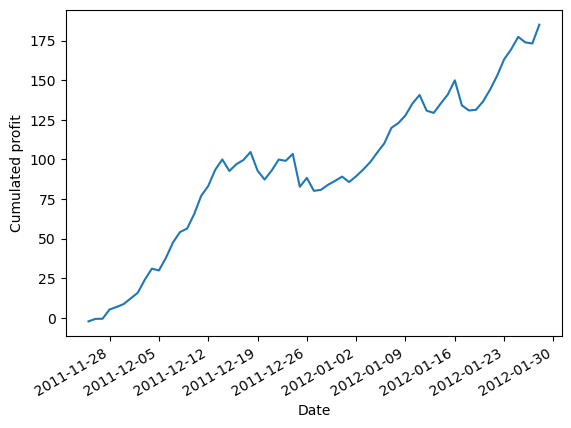

In [18]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


plt.plot(pd.to_datetime(daily_profit["date"]), daily_profit["profit"].cumsum())
plt.ylabel("Cumulated profit")
plt.xlabel("Date")
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MONDAY))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()